# MINOS reproduction

In [1]:
# Imports

import os
import sys
import pandas as pd
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Reshape, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_keras
from concurrent.futures import ThreadPoolExecutor

import keras

import matplotlib.pyplot as plt
import os

from datetime import datetime

In [2]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Using MONID for fast loading of datasets
# https://modin.readthedocs.io/en/stable/
os.environ["MODIN_CPUS"] = "16"
os.environ["MODIN_ENGINE"] = "ray"
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"
import ray
ray.shutdown()
ray.init(num_cpus=16,_temp_dir="/datadrive/ray")
import modin.pandas as pdfast

2022-01-09 17:34:49,999	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
# The following code is for latex plotting like
# Comment out this is latex is not installed in the computer
from distutils.spawn import find_executable

if find_executable('latex'): 
    print("latex installed")
    import matplotlib.pyplot as plt
    import matplotlib
    from math import sqrt
    SPINE_COLOR = 'gray'
    plt.style.use('seaborn-colorblind')
    import re

    tick_y_size = 8
    tick_x_size = 8
    title_size = 12

    def latexify(fig_width=None, fig_height=None, columns=1, font_size=12, tick_size=12):
        """Set up matplotlib's RC params for LaTeX plotting.
        Call this before plotting a figure.

        Parameters
        ----------
        fig_width : float, optional, inches
        fig_height : float,  optional, inches
        columns : {1, 2}
        """

        if fig_width is None:
            fig_width = 3.7 if columns==1 else 6.9 # width in inches

        if fig_height is None:
            golden_mean = (sqrt(5)-1.0)/2.0	# Aesthetic ratio
            fig_height = fig_width*golden_mean + 1.2 # height in inches

        pgf_with_latex = {					  # setup matplotlib to use latex for output
            "pgf.texsystem": "pdflatex",		# change this if using xetex or lautex
            "text.usetex": True,				# use LaTeX to write all text
            "font.family": "serif",
            "font.serif": [],				   # blank entries should cause plots
            "font.monospace": [],
            "axes.labelsize": font_size,			   # LaTeX default is 10pt font.
            "font.size": font_size,
            "legend.fontsize": font_size,			   # Make the legend/label fonts
            "xtick.labelsize": tick_size,			   # a little smaller
            "ytick.labelsize": tick_size,
            "figure.figsize": [fig_width, fig_height],	 # default fig size of 0.9 textwidth
            #"pgf.preamble": [
            #	r"\\usepackage[utf8x]{inputenc}",	# use utf8 fonts
            #	r"\\usepackage[T1]{fontenc}",		# plots will be generated
            #	r"\\usepackage[detect-all,locale=DE]{siunitx}",
            #	]								   # using this preamble
            }

        matplotlib.rcParams.update(pgf_with_latex)


    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):

        for spine in hide:
            ax.spines[spine].set_visible(False)

        for spine in show:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_tick_params(direction='out', color=SPINE_COLOR)

        return ax

    latexify(font_size=14, tick_size=11)
else:
    print("latex is not installed")
    
    def latexify(fig_width=None, fig_height=None, columns=1, font_size=8, tick_size=8):
        # Nothing
        pass

    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):
        # Nothing
        return ax

    latexify()

latex installed


In [5]:
# Helper methods

# Split the dataset for testing and training
def split(df, testfraction=0.5):
    cp = df.copy()    
    index_to_cut = int(len(cp.index)*(testfraction))
    shuffled = np.random.permutation(cp.index)
    pref, suf = shuffled[:index_to_cut], shuffled[index_to_cut:]
    
    assert len(pref) + len(suf) == len(cp.index)
    return cp.loc[pref], cp.loc[suf]


# Creates the folds for a given dataset
def folds(df, nofolds=10):
    chunk_size = int(len(df.index)/nofolds) + 1 # ceiling approx.
    permutation = np.random.permutation(df.index)
    
    folds = [ df.loc[permutation[chunk_size*i:chunk_size*(i + 1)]].copy() for i in range(nofolds)]
    
    return folds

# Given correct labels, returns the accuracy of the model predictions
def accuracy(df, correctlabels):
    acc = 0
    for prediction, correct in zip(df.iloc, correctlabels):
        if prediction.idxmax() == correct:
            acc += 1
            
    return acc/len(df.index)

# To plot ROC and get the AUC
def plot_roc(fpr_keras, tpr_keras, auc_keras_val, filename, title="ROC curve"):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, label='auc = {:.3f}'.format(auc_keras_val))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(title)
    ax.legend(loc='best')
    plt.tight_layout()
    
    sanitized_name = f"plots/{filename}".replace("_", ".")
    fig.savefig(sanitized_name)
    
# To plot accuracy
def plot_accuracy(epochs, accuracy, validation_acc, filename):    
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    ax.plot(epochs, accuracy, 'bo', label='Training acc')
    ax.plot(epochs, validation_acc, 'r', label='Validation acc')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and\nvalidation accuracy')
    ax.legend()    
    plt.tight_layout()
    fig.savefig(sanitized_name)


# To plot loss
def plot_loss(epochs, loss, validation_loss, filename):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot(epochs, loss, 'bo', label='Training loss')
    ax.plot(epochs, validation_loss, 'r', label='Validation loss')
    ax.set_title('Training and\nvalidation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    
    fig.savefig(sanitized_name)
    
def plot_pca(df, name):
    plt.figure() # clean the buffer
    # trying PCA to see the distribution of the samples
    from sklearn.decomposition import PCA

    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    Xb = df[df['CLASS'] == 'BENIGN']
    Xb = Xb[pixels].values
    Xm = df[df['CLASS'] == 'MALIGN']
    Xm = Xm[pixels].values

    pca = PCA(n_components=2, whiten=True).fit(X)
    X_pcab = pca.transform(Xb)
    X_pcam = pca.transform(Xm)


    row = 0
    col = 1

    plt.scatter(X_pcab[:,row],X_pcab[:,col],c='b', alpha=0.5)
    plt.scatter(X_pcam[:,row],X_pcam[:,col],c='r', alpha=0.5)

    # blue for benign
    # red for malign

    plt.savefig(name)
    
def plot_manifolds(df, name):
    plt.figure() # clean the buffer
    from sklearn.manifold import MDS
    model = MDS(n_components=2, random_state=2)
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    
    manifolds = model.fit_transform(X)
    colors = df['CLASS'].values
    colors = [[1, 0,0,0.5] if c == 'MALIGN' else [0,0,1, 0.5] for c in colors]

    plt.scatter(manifolds[:, 0], manifolds[:, 1], c=colors)
    plt.axis('equal');
    plt.savefig(name)
    
def img_sample(sample):
    
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    print(sample['Name'], sample['CLASS'])
    values = sample[pixels].values
    values = values.reshape((100,100))

    plt.imshow(np.float32(values))

# Experiments

In [6]:
# Parameters for plotting and model saving

PLOT_FIT = True
LOAD_IF_COMPILED = True

# MINOS class
class MINOS:

    # Use this field to refer to the index of the correct label,
    # for example, `MINOS.classes.index("MALIGN")` or `MINOS.classes[0]`
    classes = ['MALIGN', 'BENIGN']

    def __init__(self, size=(100,100), add_maxpool=True):

        # Create and compile the CNN following the instructions from MINOS
        model = Sequential()
        model.add(Reshape((*size, 1), input_shape=(size[0]*size[1], )))
        model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(*size,1)))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
        model.add(Flatten())
        model.add(Dense(2, activation='softmax'))

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # To print the summary of the CNN model, layers, parameters, etc
        model.summary()

        self.model = model

        
    # This method returns a collection of the image datas.
    # This method group the columns representing the pixel values, each pixel value is
    # stored in a column with the name `<row>_<column>` in the 100x100 binary transformation
    def preprocess(self, data, shape=(100,100)):
        r = data.groupby(by='CLASS').apply(lambda x: len(x))
        display(r)
        
        features = [f"{x}_{y}" for x in range(shape[0]) for y in range(shape[1])]
        # Categorize data
        labels = data['CLASS'].apply(lambda x: MINOS.classes.index(x))
        labels = to_categorical(labels)

        
        # iterate the data and load the nyd
        values = data[features].values
        return values, np.array(labels)

    # Train the classifier
    def fit(self, train_data, test_data, epochs=50, model_name="minos.h5"):
        
        # This check, will avoid to train the model again if the model 
        # was already saved in the filesystem. This will help us to prevent
        # the model creating on every exeution of the fit method.
        if not os.path.exists(model_name):
            # Some counting for info
            X_train, Y_train = self.preprocess(train_data)
            X_test, Y_test = self.preprocess(test_data)

            # for plotting
            checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                                monitor = 'val_acc',
                                verbose=1, 
                                save_best_only=True)
            history = self.model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[checkpointer], epochs=epochs)
            
            self.model.save(model_name)

            # To plot the accuracy and lost per epoch
            if PLOT_FIT:
                acc = history.history['accuracy']
                val_acc = history.history['val_accuracy']
                loss = history.history['loss']
                val_loss = history.history['val_loss']
                
                epochs = range(1, len(acc) + 1)
                plot_accuracy(epochs, acc, val_acc, f"Accuracy_{model_name}.pdf")
                plot_loss(epochs, loss, val_loss, f"Loss_{model_name}.pdf")
                
                self.acc4plot = [(epochs, acc, val_acc), (epochs, loss, val_loss)]
                
        # Otherwise, just load the model from the file system
        else:
            self.model = keras.models.load_model(model_name)
            


    # Given dataframe, uses the fitted model to 
    # predict the labels
    def predict(self, data):
        
        X, _ = self.preprocess(data)

        p = self.model.predict(X)

        d = pd.DataFrame(p, columns=MINOS.classes)
        return d

    # The predictions (predict method) are given using a column per label,
    # and setting the row values to the probability of the instance to have that 
    # class. This method, adds a new column call 'CLASS' and set the its value to the
    # name of the prediction column with higher probability
    def predict_classes(self, pd,  predictions):
        pd['CLASS'] = predictions.idxmax(axis=1)



## Getting the dataset

In [ ]:
! #TODO wget dataset folder
! #TODO unzip

## Dataset description

The datasets are presented in this works as CSV files. Each dataset has the `Name`, one column per pixel out of 100x100 and the `CLASS` colum. Each row represents a binary, for example,

```
    Name, 0_0, 0_1, 0_2, ..., CLASS
    ...
    binary1.wasm, 0, 0, 0, ..., BENIGN
    ...
```

- **original.csv**: Orignal dataset from MINOS paper.
- **augmented1_benign.csv**: AUGMENTED1 dataset for benign augmented binaries.
- **augmented1_malign.csv**: AUGMENTED1 dataset for malign augmented binaries. 
- **augmented2_benign.csv**: AUGMENTED2 dataset for benign augmented binaries.
- **augmented2_malign.csv**: AUGMENTED2 dataset for malign augmented binaries.



Since the datasets are massive, you can find a random extraction of 1k, 2k, 5k, 10k, 20k and 50k.

- augmented1_malign.1k.csv, augmented1_malign.2k.csv, augmented1_malign.5k.csv, augmented1_malign.10k.csv, augmented1_malign.20k.csv, augmented1_malign.50k.csv, augmented1_malign.100k.csv.
- augmented1_benign.1k.csv, augmented1_benign.2k.csv, augmented1_benign.5k.csv, augmented1_benign.10k.csv, augmented1_benign.20k.csv, augmented1_benign.50k.csv, augmented1_benign.100k.csv.  

CPU times: user 514 ms, sys: 141 ms, total: 655 ms
Wall time: 3.84 s
Original dataset


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130
MALIGN,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


original/1357-wasm_tetris_bg.wasm.png BENIGN


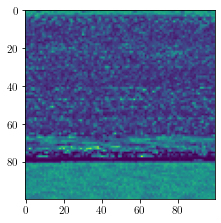

In [8]:
# Loading ORIGINAL dataset

original_data = %time pdfast.read_csv("original.csv")
print("Original dataset")

meta = original_data.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

# plotting one image as example


In [9]:
# Trying SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where

pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

oversample = SMOTE()
X, y = original_data[pixels].values, original_data['CLASS'].values

X, y = oversample.fit_resample(X, y)
    
# Comment line below to use the original dataset without SMOTE
original_data = pd.DataFrame()
original_data[pixels] = X
original_data['CLASS'] = y

display(original_data)

(apply_list_of_funcs pid=1759415) 


,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,0.266667,0.317647,0.305882,0.317647,0.294118,0.290196,0.301961,0.298039,0.298039,0.290196,...,0.364706,0.349020,0.360784,0.372549,0.349020,0.352941,0.368627,0.364706,0.388235,BENIGN
1,0.262745,0.141176,0.090196,0.196078,0.325490,0.403922,0.298039,0.305882,0.231373,0.290196,...,0.176471,0.172549,0.156863,0.184314,0.168627,0.172549,0.156863,0.207843,0.113725,MALIGN
2,0.360784,0.188235,0.298039,0.380392,0.356863,0.376471,0.321569,0.325490,0.329412,0.298039,...,0.047059,0.219608,0.039216,0.101961,0.266667,0.419608,0.160784,0.149020,0.129412,BENIGN
3,0.137255,0.258824,0.054902,0.047059,0.121569,0.070588,0.137255,0.137255,0.172549,0.141176,...,0.117647,0.184314,0.164706,0.203922,0.200000,0.015686,0.011765,0.000000,0.015686,BENIGN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.333762,0.301925,0.206101,0.203939,0.195257,0.283228,0.168163,0.220894,0.220474,0.306740,...,0.483264,0.505060,0.538541,0.514592,0.595292,0.469695,0.510259,0.509339,0.548555,MALIGN
256,0.291286,0.188744,0.147277,0.215105,0.304560,0.348743,0.210515,0.246899,0.221859,0.286391,...,0.359130,0.376138,0.324301,0.340335,0.448325,0.298127,0.345230,0.329616,0.300190,MALIGN
257,0.308970,0.324939,0.179276,0.281773,0.206422,0.323801,0.286825,0.254344,0.339197,0.269479,...,0.417643,0.470015,0.504215,0.525490,0.515668,0.419064,0.349600,0.470886,0.454648,MALIGN
258,0.368627,0.253970,0.162276,0.255337,0.260315,0.434362,0.352444,0.352693,0.253907,0.278804,...,0.500034,0.534893,0.433491,0.454343,0.534955,0.549647,0.592411,0.349703,0.585625,MALIGN


## Training MINOS with the original dataset

Fiting classifier 208 52


2022-01-09 17:35:07.976651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 17:35:09.234872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10792 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

CLASS
BENIGN    20
MALIGN    32
dtype: int64

2022-01-09 17:35:10.578599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-09 17:35:11.057308: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Accuracy: 1.0


CLASS
BENIGN    20
MALIGN    32
dtype: int64

Plotting plots/ROC.ORIGINAL.pdf


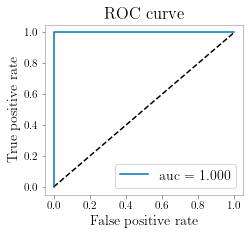

In [10]:
# We use the same plot proposed in minos, 80-20
train, test = split(original_data, 0.8)


print("Fiting classifier", len(train), len(test))
minos = MINOS()
minos.fit(train, test, model_name="original23.h5")
test_labels = test["CLASS"]
predictions = minos.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

predictions = minos.predict(test).values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_ORIGINAL.pdf")


## Getting augmented data and passing it to the original model


CPU times: user 2.97 s, sys: 3.35 s, total: 6.32 s
Wall time: 1min 5s
CPU times: user 2.81 s, sys: 2.69 s, total: 5.5 s
Wall time: 48.7 s
Augmented dataset


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_basic4gl.wasm.1274...,0.160784,0.164706,0.164706,0.168627,0.168627,0.168627,0.168627,0.168627,0.164706,...,0.337255,0.325490,0.317647,0.301961,0.298039,0.313725,0.325490,0.313725,0.341176,BENIGN
1,augmented_benign_bfs/bening_micr.io.wasm.516.w...,0.282353,0.168627,0.250980,0.247059,0.211765,0.262745,0.219608,0.172549,0.258824,...,0.329412,0.454902,0.474510,0.305882,0.356863,0.435294,0.549020,0.341176,0.494118,BENIGN
2,augmented_benign_bfs/bening_jakedeichert.githu...,0.156863,0.168627,0.172549,0.164706,0.160784,0.172549,0.168627,0.176471,0.176471,...,0.227451,0.219608,0.235294,0.258824,0.227451,0.227451,0.341176,0.219608,0.168627,BENIGN
3,augmented_benign_bfs/bening_creaturepack-wasm....,0.168627,0.172549,0.172549,0.172549,0.172549,0.164706,0.160784,0.164706,0.164706,...,0.301961,0.286275,0.301961,0.301961,0.305882,0.286275,0.309804,0.317647,0.294118,BENIGN
4,augmented_benign_bfs/bening_ammo.wasm.wasm.145...,0.156863,0.164706,0.160784,0.160784,0.160784,0.164706,0.160784,0.160784,0.160784,...,0.317647,0.309804,0.294118,0.286275,0.278431,0.290196,0.321569,0.301961,0.321569,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,augmented_malign_bfs/malign_bluegrassrivals.co...,0.164706,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.513725,0.486275,0.407843,0.427451,0.478431,0.466667,0.450980,0.486275,0.482353,MALIGN
39996,augmented_malign_bfs/malign_justproxy.co.uk.wa...,0.168627,0.156863,0.176471,0.164706,0.180392,0.180392,0.172549,0.180392,0.180392,...,0.317647,0.400000,0.490196,0.490196,0.447059,0.380392,0.415686,0.454902,0.349020,MALIGN
39997,augmented_malign_bfs/malign_browsermine.com_c7...,0.160784,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.486275,0.470588,0.478431,0.498039,0.490196,0.482353,0.450980,0.494118,0.494118,MALIGN
39998,augmented_malign_bfs/malign_hevcbay.com_440f91...,0.184314,0.145098,0.180392,0.180392,0.176471,0.164706,0.184314,0.176471,0.192157,...,0.192157,0.192157,0.227451,0.184314,0.235294,0.282353,0.207843,0.223529,0.203922,MALIGN


(apply_list_of_funcs pid=1759639) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
MALIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
MALIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


(compute_sliced_len pid=1759629) 


Accuracy: 0.508
Plotting plots/ROC.AUGNMENTED.BREAKING1.SIZE40000.pdf


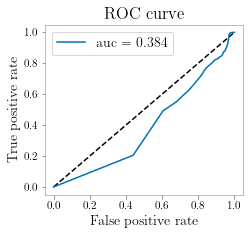

In [11]:
# The augmented dataset is massive, to be able to make the proof of concept we generated
# the datasets by using `shuf -n <SIZE> ...` to the original 36Gb dataset to get a random 
# permutation of the complete dataset

# Comment out the datasets to load less or more data

# augmented_benign = %time pdfast.read_csv("augmented1_benign.1k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.1k.csv")

# augmented_benign = %time pdfast.read_csv("augmented1_benign.2k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.2k.csv")


# augmented_benign = %time pdfast.read_csv("augmented1_benign.5k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.5k.csv")

augmented_benign = %time pdfast.read_csv("augmented1_benign.20k.csv")
augmented_malign = %time pdfast.read_csv("augmented1_malign.20k.csv")


augmented1 = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)
print("Augmented dataset")
display(augmented1)
meta = augmented1.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented1["CLASS"]
predictions = minos.predict(augmented1)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_SIZE{len(augmented1)}.pdf")

## Step 2, training on augmented

Fiting classifier 32000 8000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)       

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051
MALIGN,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949


Accuracy: 1.0


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051,4051
MALIGN,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949,3949


(apply_func pid=1759413) 
Plotting plots/ROC.AUGMENTED.pdf


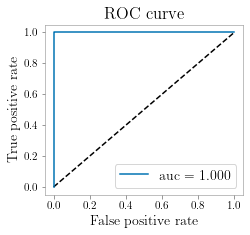

In [12]:
train, test = split(augmented1, 0.8)


print("Fiting classifier", len(train), len(test))
minos2 = MINOS()
minos2.fit(train, test, epochs=50, model_name="with_augmentation14.h5")
test_labels = test["CLASS"]
predictions = minos2.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

predictions = minos2.predict(test).values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGMENTED.pdf")


CPU times: user 635 ms, sys: 241 ms, total: 876 ms
Wall time: 10.6 s
CPU times: user 552 ms, sys: 139 ms, total: 690 ms
Wall time: 1.78 s


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_www.figma.com.wasm...,0.149020,0.172549,0.176471,0.164706,0.160784,0.172549,0.176471,0.176471,0.168627,...,0.239216,0.203922,0.203922,0.133333,0.180392,0.152941,0.149020,0.164706,0.192157,BENIGN
1,augmented_benign_bfs/bening_basic4gl.wasm.937....,0.176471,0.196078,0.188235,0.200000,0.188235,0.200000,0.180392,0.188235,0.196078,...,0.380392,0.329412,0.329412,0.376471,0.431373,0.419608,0.431373,0.419608,0.435294,BENIGN
2,augmented_benign_bfs/bening_developers.arcgis....,0.152941,0.156863,0.172549,0.172549,0.180392,0.180392,0.176471,0.180392,0.168627,...,0.384314,0.262745,0.352941,0.290196,0.305882,0.290196,0.278431,0.290196,0.235294,BENIGN
3,augmented_benign_bfs/bening_canvas.apps.chrome...,0.145098,0.149020,0.152941,0.149020,0.149020,0.145098,0.149020,0.149020,0.149020,...,0.301961,0.305882,0.301961,0.278431,0.266667,0.266667,0.262745,0.262745,0.274510,BENIGN
4,augmented_benign_bfs/bening_boyan.io5.wasm.980...,0.160784,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.203922,0.200000,0.207843,0.192157,0.188235,0.192157,0.200000,0.200000,0.196078,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,augmented_malign_bfs/malign_pharmatips.in.wasm...,0.160784,0.164706,0.164706,0.168627,0.168627,0.164706,0.164706,0.164706,0.164706,...,0.466667,0.384314,0.407843,0.341176,0.407843,0.407843,0.458824,0.450980,0.400000,MALIGN
1996,augmented_malign_bfs/malign_creative-solutions...,0.172549,0.168627,0.168627,0.168627,0.168627,0.172549,0.172549,0.172549,0.168627,...,0.517647,0.494118,0.462745,0.509804,0.458824,0.513725,0.470588,0.490196,0.454902,MALIGN
1997,augmented_malign_bfs/malign_tainiesonline.top....,0.160784,0.164706,0.168627,0.168627,0.168627,0.168627,0.164706,0.164706,0.164706,...,0.396078,0.400000,0.403922,0.396078,0.431373,0.427451,0.458824,0.411765,0.458824,MALIGN
1998,augmented_malign_bfs/malign_desirefx.me_12ee11...,0.156863,0.164706,0.172549,0.168627,0.172549,0.172549,0.172549,0.172549,0.176471,...,0.364706,0.356863,0.384314,0.396078,0.396078,0.349020,0.360784,0.305882,0.282353,MALIGN


Augmented dataset


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
MALIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
MALIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


(apply_list_of_funcs pid=1759201) 
Accuracy: 1.0
Plotting plots/ROC.AUGNMENTED.BREAKING1.VALIDATION.SIZE2000.pdf


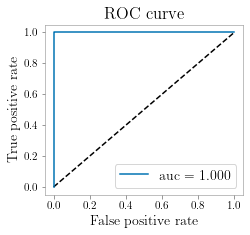

In [13]:
# Validating that the model learned this distribution


augmented_benign1 = %time pdfast.read_csv("augmented1_benign.1k.csv")
augmented_malign1 = %time pdfast.read_csv("augmented1_malign.1k.csv")


augmented11 = pdfast.concat([augmented_benign1, augmented_malign1], axis=0, ignore_index=True)

display(augmented11)

print("Augmented dataset")
meta = augmented11.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented11["CLASS"]
predictions = minos2.predict(augmented11)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_VALIDATION_SIZE{len(augmented11)}.pdf")

## Step 3

Try with another distribution on the augmented model

If the model learns the obfuscation on AUGMENTED1, what happens when the obfuscation follows another distribution ?

CPU times: user 4.11 s, sys: 3.3 s, total: 7.41 s
Wall time: 1min 19s
CPU times: user 5.1 s, sys: 3.77 s, total: 8.87 s
Wall time: 1min 20s


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs_5k_100_1234/bening_svg_as...,0.360784,0.188235,0.298039,0.380392,0.356863,0.376471,0.321569,0.325490,0.329412,...,0.184314,0.129412,0.062745,0.070588,0.113725,0.027451,0.086275,0.196078,0.039216,BENIGN
1,4/bening_wasm_astar.wasm.5.wasm.png,0.305882,0.278431,0.184314,0.184314,0.109804,0.266667,0.313725,0.294118,0.270588,...,0.133333,0.125490,0.141176,0.121569,0.098039,0.149020,0.235294,0.109804,0.184314,BENIGN
2,augmented_benign_bfs_5k_100_1234/bening_usindi...,0.000000,0.000000,0.000000,0.105882,0.247059,0.360784,0.427451,0.466667,0.486275,...,0.117647,0.058824,0.000000,0.000000,0.000000,0.054902,0.101961,0.129412,0.141176,BENIGN
3,augmented_benign_bfs_5k_100_1234/bening_wasm_a...,0.274510,0.243137,0.172549,0.188235,0.105882,0.250980,0.305882,0.294118,0.266667,...,0.078431,0.141176,0.125490,0.086275,0.145098,0.129412,0.062745,0.086275,0.117647,BENIGN
4,augmented_benign_bfs_5k_100_1234/bening_hebjem...,0.000000,0.000000,0.003922,0.062745,0.141176,0.231373,0.321569,0.384314,0.427451,...,0.309804,0.160784,0.082353,0.043137,0.023529,0.015686,0.011765,0.003922,0.000000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.478431,0.447059,0.501961,0.462745,0.490196,0.450980,0.407843,0.474510,0.486275,MALIGN
19996,augmented_malign_bfs_5k_100_1234/malign_worker...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.450980,0.450980,0.458824,0.454902,0.450980,0.470588,0.450980,0.435294,0.447059,MALIGN
19997,augmented_malign_bfs_5k_100_1234/malign_webmin...,0.160784,0.168627,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,...,0.466667,0.474510,0.486275,0.509804,0.466667,0.458824,0.498039,0.458824,0.498039,MALIGN
19998,augmented_malign_bfs_5k_100_1234/malign_uzhasn...,0.160784,0.164706,0.168627,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.376471,0.376471,0.443137,0.427451,0.407843,0.427451,0.439216,0.458824,0.470588,MALIGN


Augmented dataset 2


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
MALIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
MALIGN,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


Accuracy: 0.55945
Plotting plots/ROC.AUGNMENTED.BREAKING2.SIZE20000.pdf


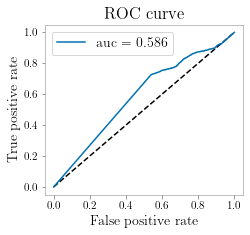

In [14]:
augmented_benign3 = %time pdfast.read_csv("augmented2_benign.csv")
augmented_malign3 = %time pdfast.read_csv("augmented2_malign.csv")


# Set the classes to the same representation
# comment out to use the original one
augmented_benign3 = augmented_benign3.iloc[:10000]
augmented_malign3 = augmented_malign3.iloc[:10000]
augmented3 = pdfast.concat([augmented_benign3, augmented_malign3], axis=0, ignore_index=True)

display(augmented3)

print("Augmented dataset 2")
meta = augmented3.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented3["CLASS"]
predictions = minos2.predict(augmented3)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING2_SIZE{len(augmented3)}.pdf")

The question is now, which transformations make the classifier to be innacurate, where is that 20% of failure ?

Future work: make wasm-mutate feature based to detect which kind of transformations.

#### The report stops HERE !!!!










# Evaluating specific mutators

Assoc
CPU times: user 460 ms, sys: 81.7 ms, total: 541 ms
Wall time: 1.83 s
CPU times: user 415 ms, sys: 27.5 ms, total: 442 ms
Wall time: 1.24 s
Augmented dataset (Assoc)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196
MALIGN,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196
MALIGN,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


Accuracy (Assoc): 0.9148936170212766
Plotting plots/ROC.AUGNMENTED.BREAKING.Assoc.pdf


Select flip
CPU times: user 443 ms, sys: 64.7 ms, total: 508 ms
Wall time: 1.78 s
CPU times: user 356 ms, sys: 17 ms, total: 373 ms
Wall time: 859 ms
Augmented dataset (Select flip)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181
MALIGN,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181
MALIGN,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


Accuracy (Select flip): 0.9
Plotting plots/ROC.AUGNMENTED.BREAKING.Select flip.pdf


StrengthReduction
CPU times: user 518 ms, sys: 80.2 ms, total: 598 ms
Wall time: 2.21 s
CPU times: user 447 ms, sys: 60.4 ms, total: 508 ms
Wall time: 1.76 s
Augmented dataset (StrengthReduction)
(deploy_ray_func pid=1759413) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,344,344,344,344,344,344,344,344,344,344,344,344,344,344,344,344
MALIGN,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,344,344,344,344,344,344,344,344,344,344,344,344,344,344,344,344
MALIGN,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185


Accuracy (StrengthReduction): 0.888468809073724
Plotting plots/ROC.AUGNMENTED.BREAKING.StrengthReduction.pdf


Globals
CPU times: user 2.67 s, sys: 3.02 s, total: 5.69 s
Wall time: 49.2 s
CPU times: user 2.75 s, sys: 2.74 s, total: 5.49 s
Wall time: 48.6 s
Augmented dataset (Globals)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


Accuracy (Globals): 0.5848
Plotting plots/ROC.AUGNMENTED.BREAKING.Globals.pdf
(apply_func pid=1759415) 


Idem
CPU times: user 2.31 s, sys: 2.59 s, total: 4.89 s
Wall time: 48.9 s
CPU times: user 2.72 s, sys: 2.35 s, total: 5.07 s
Wall time: 49.4 s
Augmented dataset (Idem)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


(apply_list_of_funcs pid=1759415) 


Accuracy (Idem): 0.5175333333333333
Plotting plots/ROC.AUGNMENTED.BREAKING.Idem.pdf


Neutral
CPU times: user 2.28 s, sys: 2.62 s, total: 4.9 s
Wall time: 48.6 s
CPU times: user 2.31 s, sys: 2.56 s, total: 4.87 s
Wall time: 48.4 s
Augmented dataset (Neutral)
(apply_list_of_funcs pid=1807788) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000
MALIGN,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000,15000


Accuracy (Neutral): 0.9051333333333333
Plotting plots/ROC.AUGNMENTED.BREAKING.Neutral.pdf


UNFOLD
CPU times: user 4.95 s, sys: 5.43 s, total: 10.4 s
Wall time: 2min 1s
CPU times: user 1.21 s, sys: 1.41 s, total: 2.62 s
Wall time: 23.1 s
Augmented dataset (UNFOLD)
(apply_list_of_funcs pid=1759629) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975
MALIGN,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975,31975
MALIGN,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130,7130


(apply_list_of_funcs pid=1759416) 
Accuracy (UNFOLD): 0.9760388697097558
Plotting plots/ROC.AUGNMENTED.BREAKING.UNFOLD.pdf




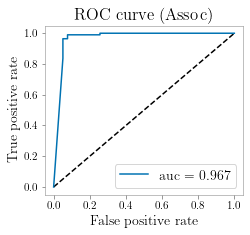

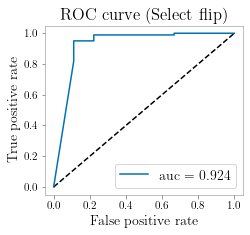

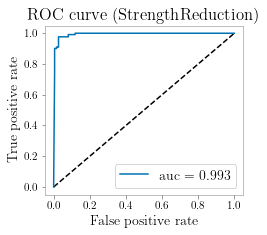

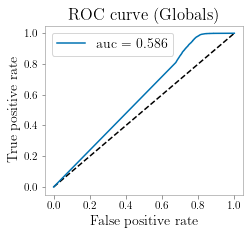

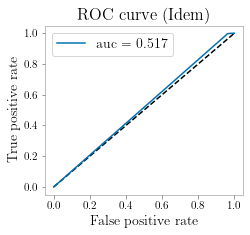

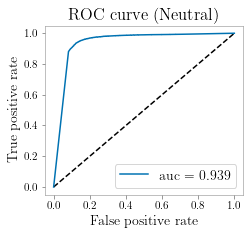

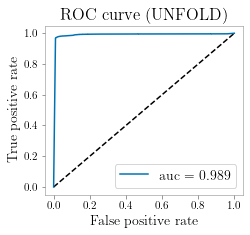

In [18]:
datasets = [
    ("by_mutators/groupingpeep-assoc_benign.csv", "by_mutators/groupingpeep-assoc_malign.csv", "Assoc"),
    ("by_mutators/groupingpeep-select-flip_benign.csv", "by_mutators/groupingpeep-select-flip_malign.csv", "Select flip"),
    ("by_mutators/groupingpeep-strength_benign.csv", "by_mutators/groupingpeep-strength_malign.csv", "StrengthReduction"),
    ("by_mutators/groupingpeep-globals_benign.15k.csv", "by_mutators/groupingpeep-globals_malign.15k.csv", "Globals"),
    ("by_mutators/groupingpeep-idem_benign.15k.csv", "by_mutators/groupingpeep-idem_malign.15k.csv", "Idem"),
    ("by_mutators/groupingpeep-neutral_benign.15k.csv", "by_mutators/groupingpeep-neutral_malign.15k.csv", "Neutral"),
    ("augmented_unfold_benign.csv", "augmented_unfold_malign.csv", "UNFOLD"),
]

for i, (benign, malign, name) in enumerate(datasets):
    print(name)

    augmented_benign = %time pdfast.read_csv(benign)
    augmented_malign = %time pdfast.read_csv(malign)


    augmented = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)



    print(f"Augmented dataset ({name})")
    meta = augmented.groupby(by='CLASS').apply(lambda x: len(x))
    display(meta)

    test_labels = augmented["CLASS"]
    predictions = minos2.predict(augmented)

    print(f"Accuracy ({name}): {accuracy(predictions, test_labels)}")
    predictions = predictions.values

    test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
    auc_keras_val = auc_keras(fpr_keras, tpr_keras)


    # Potting roc 
    plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING_{name}.pdf", title=f"ROC curve ({name})")
    print("======================================================\n\n")

Assoc
CPU times: user 468 ms, sys: 37.3 ms, total: 505 ms
Wall time: 1.31 s
CPU times: user 405 ms, sys: 95.2 ms, total: 500 ms
Wall time: 1.07 s
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                   

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153
MALIGN,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
MALIGN,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 0.5402 - accuracy: 0.8062WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 1s 55ms/step - loss: 0.5412 - accuracy: 0.8138 - val_loss: 0.3493 - val_accuracy: 0.9149
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.5182 - accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 21ms/step - loss: 0.4962 - accuracy: 0.8138 - val_loss: 0.2999 - val_accuracy: 0.9149
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.5014 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 23ms/step - loss: 0.4944 - accuracy: 0.8138 - val_loss: 0.2871 - val_accuracy: 0.9149
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4337 - accuracy: 0.8188WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 20ms/step - loss: 0.4641 - accuracy: 0.7872 - val_loss: 0.2763 - val_accuracy: 0.9149
Epoch 5/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4015 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 20ms/step - loss: 0.3702 - accuracy: 0.8511 - val_loss: 0.2067 - val_accuracy: 0.9149
Epoch 6/50
5/6 [========================>.....] - ETA: 0s - loss: 0.3234 - accuracy: 0.8875WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 21ms/step - loss: 0.3206 - accuracy: 0.8936 - val_loss: 0.2398 - val_accuracy: 0.9574
Epoch 7/50
5/6 [========================>.....] - ETA: 0s - loss: 0.2377 - accuracy: 0.9563WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 21ms/step - loss: 0.3026 - accuracy: 0.9309 - val_loss: 0.3149 - val_accuracy: 0.8723
Epoch 8/50
5/6 [========================>.....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9500WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 20ms/step - loss: 0.2315 - accuracy: 0.9362 - val_loss: 0.2607 - val_accuracy: 0.8936
Epoch 9/50
5/6 [========================>.....] - ETA: 0s - loss: 0.2673 - accuracy: 0.9000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 19ms/step - loss: 0.2444 - accuracy: 0.9149 - val_loss: 0.1175 - val_accuracy: 0.9787
Epoch 10/50
5/6 [========================>.....] - ETA: 0s - loss: 0.1780 - accuracy: 0.9500WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 22ms/step - loss: 0.1729 - accuracy: 0.9521 - val_loss: 0.1001 - val_accuracy: 0.9787
Epoch 11/50
6/6 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9628WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 19ms/step - loss: 0.1608 - accuracy: 0.9628 - val_loss: 0.1162 - val_accuracy: 0.9574
Epoch 12/50
6/6 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9309WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.2282 - accuracy: 0.9309 - val_loss: 0.3052 - val_accuracy: 0.8511
Epoch 13/50
5/6 [========================>.....] - ETA: 0s - loss: 0.1572 - accuracy: 0.9625WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 23ms/step - loss: 0.1592 - accuracy: 0.9628 - val_loss: 0.1373 - val_accuracy: 0.9362
Epoch 14/50
6/6 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9521WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.1281 - accuracy: 0.9521 - val_loss: 0.0697 - val_accuracy: 0.9787
Epoch 15/50
6/6 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9362WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 19ms/step - loss: 0.1914 - accuracy: 0.9362 - val_loss: 0.1267 - val_accuracy: 0.9787
Epoch 16/50
6/6 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9628WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 21ms/step - loss: 0.1231 - accuracy: 0.9628 - val_loss: 0.0579 - val_accuracy: 0.9787
Epoch 17/50
6/6 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9309WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.1932 - accuracy: 0.9309 - val_loss: 0.0666 - val_accuracy: 0.9787
Epoch 18/50
6/6 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9628WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.1124 - accuracy: 0.9628 - val_loss: 0.0695 - val_accuracy: 0.9787
Epoch 19/50
6/6 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9681WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0979 - accuracy: 0.9681 - val_loss: 0.1072 - val_accuracy: 0.9574
Epoch 20/50
6/6 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9468WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.1296 - accuracy: 0.9468 - val_loss: 0.0807 - val_accuracy: 0.9787
Epoch 21/50
6/6 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0882 - accuracy: 0.9840 - val_loss: 0.0903 - val_accuracy: 0.9787
Epoch 22/50
6/6 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9787WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0830 - accuracy: 0.9787 - val_loss: 0.0464 - val_accuracy: 0.9787
Epoch 23/50
6/6 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9521WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.1436 - accuracy: 0.9521 - val_loss: 0.0783 - val_accuracy: 0.9787
Epoch 24/50
6/6 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 20ms/step - loss: 0.0834 - accuracy: 0.9840 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 25/50
6/6 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9734WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0617 - accuracy: 0.9734 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 26/50
6/6 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9628WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.1724 - accuracy: 0.9628 - val_loss: 0.0486 - val_accuracy: 1.0000
Epoch 27/50
6/6 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 19ms/step - loss: 0.0583 - accuracy: 0.9840 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 28/50
6/6 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0540 - accuracy: 0.9840 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 29/50
6/6 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0459 - accuracy: 0.9894 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 30/50
6/6 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9787WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0743 - accuracy: 0.9787 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 31/50
6/6 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0563 - accuracy: 0.9894 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 32/50
6/6 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9840WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 33/50
6/6 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0336 - accuracy: 0.9894 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 34/50
6/6 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0224 - accuracy: 0.9947 - val_loss: 0.0608 - val_accuracy: 0.9787
Epoch 35/50
6/6 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9787WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0745 - accuracy: 0.9787 - val_loss: 0.0810 - val_accuracy: 0.9787
Epoch 36/50
6/6 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0217 - accuracy: 0.9947 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 37/50
6/6 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 21ms/step - loss: 0.0212 - accuracy: 0.9947 - val_loss: 0.0593 - val_accuracy: 1.0000
Epoch 38/50
6/6 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0222 - accuracy: 0.9947 - val_loss: 0.1974 - val_accuracy: 0.9149
Epoch 39/50
6/6 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0322 - accuracy: 0.9947 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 40/50
6/6 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0260 - accuracy: 0.9894 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 41/50
6/6 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0125 - accuracy: 0.9947 - val_loss: 0.3229 - val_accuracy: 0.8511
Epoch 42/50
6/6 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0487 - accuracy: 0.9894 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 43/50
6/6 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 44/50
6/6 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 45/50
6/6 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 46/50
6/6 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 47/50
6/6 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 17ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2915 - val_accuracy: 0.8936
Epoch 48/50
6/6 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0399 - accuracy: 0.9894 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 49/50
6/6 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 50/50
6/6 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Plotting plots/Accuracy.Assoc.model.h5.pdf
Plotting plots/Loss.Assoc.model.h5.pdf
Augmented dataset (Assoc)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153
MALIGN,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
MALIGN,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
MALIGN,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


Accuracy: 1.0
Plotting plots/ROC.TRAIN.Assoc.pdf


Select flip
CPU times: user 453 ms, sys: 102 ms, total: 555 ms
Wall time: 1.5 s
CPU times: user 364 ms, sys: 31.7 ms, total: 396 ms
Wall time: 862 ms
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 23, 23, 32)  

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144
MALIGN,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
MALIGN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8158WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 1s 63ms/step - loss: 0.4101 - accuracy: 0.8158 - val_loss: 0.1747 - val_accuracy: 0.9737
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 22ms/step - loss: 0.2373 - accuracy: 0.9474 - val_loss: 0.1573 - val_accuracy: 0.9737
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 25ms/step - loss: 0.2271 - accuracy: 0.9474 - val_loss: 0.1529 - val_accuracy: 0.9737
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 22ms/step - loss: 0.2192 - accuracy: 0.9474 - val_loss: 0.2272 - val_accuracy: 0.9737
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.2306 - accuracy: 0.9474 - val_loss: 0.1492 - val_accuracy: 0.9737
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.2606 - accuracy: 0.9474 - val_loss: 0.1476 - val_accuracy: 0.9737
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 22ms/step - loss: 0.2324 - accuracy: 0.9474 - val_loss: 0.1473 - val_accuracy: 0.9737
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 25ms/step - loss: 0.2146 - accuracy: 0.9474 - val_loss: 0.1439 - val_accuracy: 0.9737
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2547 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2350 - accuracy: 0.9474 - val_loss: 0.1450 - val_accuracy: 0.9737
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.2451 - accuracy: 0.9474 - val_loss: 0.1481 - val_accuracy: 0.9737
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9474WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.2159 - accuracy: 0.9474 - val_loss: 0.1434 - val_accuracy: 0.9737
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3029 - accuracy: 0.9062WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2241 - accuracy: 0.9474 - val_loss: 0.1329 - val_accuracy: 0.9737
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 23ms/step - loss: 0.2146 - accuracy: 0.9474 - val_loss: 0.1513 - val_accuracy: 0.9737
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2288 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2074 - accuracy: 0.9474 - val_loss: 0.1272 - val_accuracy: 0.9737
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2277 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2080 - accuracy: 0.9474 - val_loss: 0.1626 - val_accuracy: 0.9737
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1662 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.2287 - accuracy: 0.9474 - val_loss: 0.1205 - val_accuracy: 0.9737
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2367 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.1965 - accuracy: 0.9474 - val_loss: 0.1343 - val_accuracy: 0.9737
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2022 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.1832 - accuracy: 0.9474 - val_loss: 0.1372 - val_accuracy: 0.9737
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1343 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2156 - accuracy: 0.9474 - val_loss: 0.1301 - val_accuracy: 0.9737
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1711 - accuracy: 0.9375WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1814 - accuracy: 0.9474 - val_loss: 0.1012 - val_accuracy: 0.9737
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5075 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.2109 - accuracy: 0.9474 - val_loss: 0.0988 - val_accuracy: 0.9737
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1442 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.1541 - accuracy: 0.9474 - val_loss: 0.0909 - val_accuracy: 0.9737
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3391 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.1867 - accuracy: 0.9474 - val_loss: 0.0800 - val_accuracy: 0.9737
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0884 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1414 - accuracy: 0.9474 - val_loss: 0.0714 - val_accuracy: 0.9737
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0810 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1258 - accuracy: 0.9539 - val_loss: 0.0613 - val_accuracy: 0.9737
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9539WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 21ms/step - loss: 0.1520 - accuracy: 0.9539 - val_loss: 0.0547 - val_accuracy: 0.9737
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0622 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1182 - accuracy: 0.9605 - val_loss: 0.0838 - val_accuracy: 1.0000
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1084 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.0980 - accuracy: 0.9737 - val_loss: 0.0400 - val_accuracy: 1.0000
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0662 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0953 - accuracy: 0.9868 - val_loss: 0.0499 - val_accuracy: 0.9737
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1198 - accuracy: 0.9671 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0822 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0857 - accuracy: 0.9737 - val_loss: 0.0338 - val_accuracy: 1.0000
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0353 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0697 - accuracy: 0.9868 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1171 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0769 - accuracy: 0.9803 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0577 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0542 - accuracy: 0.9868 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0568 - accuracy: 0.9868 - val_loss: 0.0697 - val_accuracy: 0.9737
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5293 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.1504 - accuracy: 0.9671 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.0377 - accuracy: 0.9868 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0291 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 24ms/step - loss: 0.0304 - accuracy: 0.9868 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0493 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0281 - accuracy: 0.9934 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.0543 - accuracy: 0.9868 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0286 - accuracy: 0.9868 - val_loss: 0.0424 - val_accuracy: 0.9737
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0180 - accuracy: 0.9934 - val_loss: 0.1257 - val_accuracy: 0.9737
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1514 - accuracy: 0.9688WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 23ms/step - loss: 0.0857 - accuracy: 0.9803 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0108 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 20ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0139 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0076 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5/5 [==============================] - 0s 19ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 1.0000
Plotting plots/Accuracy.Select flip.model.h5.pdf
Plotting plots/Loss.Select flip.model.h5.pdf
Augmented dataset (Select flip)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144,144
MALIGN,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
MALIGN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
MALIGN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Accuracy: 1.0
Plotting plots/ROC.TRAIN.Select flip.pdf


StrengthReduction
CPU times: user 484 ms, sys: 130 ms, total: 614 ms
Wall time: 1.76 s
CPU times: user 434 ms, sys: 68.2 ms, total: 503 ms
Wall time: 1.51 s


(apply_list_of_funcs pid=1759629) 


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 21, 21, 64)      

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,272,272,272,272,272,272,272,272,272,272,272,272,272,272,272,272
MALIGN,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
MALIGN,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


(apply_list_of_funcs pid=1759415) 


Epoch 1/50
10/14 [====================>.........] - ETA: 0s - loss: 0.6814 - accuracy: 0.6906WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 1s 28ms/step - loss: 0.6728 - accuracy: 0.6690 - val_loss: 0.5918 - val_accuracy: 0.9623
Epoch 2/50
10/14 [====================>.........] - ETA: 0s - loss: 0.5402 - accuracy: 0.7844WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.5063 - accuracy: 0.8156 - val_loss: 0.4963 - val_accuracy: 0.7642
Epoch 3/50
10/14 [====================>.........] - ETA: 0s - loss: 0.3623 - accuracy: 0.8750WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 16ms/step - loss: 0.3294 - accuracy: 0.8936 - val_loss: 0.3644 - val_accuracy: 0.8491
Epoch 4/50
11/14 [======================>.......] - ETA: 0s - loss: 0.2067 - accuracy: 0.9403WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.1978 - accuracy: 0.9456 - val_loss: 0.1243 - val_accuracy: 0.9623
Epoch 5/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1543 - accuracy: 0.9347WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.1693 - accuracy: 0.9362 - val_loss: 0.1708 - val_accuracy: 0.9340
Epoch 6/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1734 - accuracy: 0.9545WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.1628 - accuracy: 0.9551 - val_loss: 0.6021 - val_accuracy: 0.7547
Epoch 7/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1780 - accuracy: 0.9432WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.1717 - accuracy: 0.9433 - val_loss: 0.1219 - val_accuracy: 0.9811
Epoch 8/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1001 - accuracy: 0.9744WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.0905 - accuracy: 0.9787 - val_loss: 0.0815 - val_accuracy: 0.9811
Epoch 9/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1298 - accuracy: 0.9631WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.1168 - accuracy: 0.9669 - val_loss: 0.0319 - val_accuracy: 1.0000
Epoch 10/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0498 - accuracy: 0.9886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0754 - accuracy: 0.9835 - val_loss: 0.1051 - val_accuracy: 0.9528
Epoch 11/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0744 - accuracy: 0.9830WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0663 - accuracy: 0.9858 - val_loss: 0.0689 - val_accuracy: 0.9717
Epoch 12/50
11/14 [======================>.......] - ETA: 0s - loss: 0.1093 - accuracy: 0.9631WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.1080 - accuracy: 0.9622 - val_loss: 0.0269 - val_accuracy: 0.9906
Epoch 13/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0517 - accuracy: 0.9858WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0446 - accuracy: 0.9882 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 14/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0606 - accuracy: 0.9830WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0531 - accuracy: 0.9858 - val_loss: 0.0269 - val_accuracy: 0.9906
Epoch 15/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0851 - accuracy: 0.9602WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0989 - accuracy: 0.9574 - val_loss: 0.0322 - val_accuracy: 0.9906
Epoch 16/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0290 - accuracy: 0.9915WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0374 - accuracy: 0.9905 - val_loss: 0.0145 - val_accuracy: 0.9906
Epoch 17/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0200 - accuracy: 0.9943WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0363 - accuracy: 0.9905 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 18/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0333 - accuracy: 0.9915WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0545 - accuracy: 0.9787 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 19/50
14/14 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9882WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 17ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 20/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0278 - accuracy: 0.9886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0297 - accuracy: 0.9882 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 21/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0328 - accuracy: 0.9886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 22/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0188 - accuracy: 0.9943WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0234 - accuracy: 0.9929 - val_loss: 0.0291 - val_accuracy: 0.9906
Epoch 23/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0425 - accuracy: 0.9858WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.0394 - accuracy: 0.9858 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 24/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0180 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0190 - accuracy: 0.9953 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 25/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0166 - accuracy: 0.9943WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 26/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 27/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0617 - accuracy: 0.9744WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0521 - accuracy: 0.9787 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 28/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0096 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 29/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 30/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 31/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0297 - accuracy: 0.9886  WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 32/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 33/50
10/14 [====================>.........] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 34/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 35/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0446 - accuracy: 0.9830  WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0373 - accuracy: 0.9858 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 36/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000    WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 37/50
11/14 [======================>.......] - ETA: 0s - loss: 9.0378e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 8.2844e-04 - accuracy: 1.0000 - val_loss: 6.7583e-04 - val_accuracy: 1.0000
Epoch 38/50
11/14 [======================>.......] - ETA: 0s - loss: 6.5309e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 6.4532e-04 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 39/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0060 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.0143 - val_accuracy: 0.9906
Epoch 40/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 15ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 5.7455e-04 - val_accuracy: 1.0000
Epoch 41/50
11/14 [======================>.......] - ETA: 0s - loss: 5.4476e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 4.8531e-04 - accuracy: 1.0000 - val_loss: 3.0920e-04 - val_accuracy: 1.0000
Epoch 42/50
11/14 [======================>.......] - ETA: 0s - loss: 3.3738e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 3.5635e-04 - accuracy: 1.0000 - val_loss: 4.9685e-04 - val_accuracy: 1.0000
Epoch 43/50
11/14 [======================>.......] - ETA: 0s - loss: 5.1799e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 4.5495e-04 - accuracy: 1.0000 - val_loss: 6.8793e-05 - val_accuracy: 1.0000
Epoch 44/50
11/14 [======================>.......] - ETA: 0s - loss: 1.3049e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 2.0318e-04 - accuracy: 1.0000 - val_loss: 7.1652e-05 - val_accuracy: 1.0000
Epoch 45/50
11/14 [======================>.......] - ETA: 0s - loss: 1.7038e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.9976 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 46/50
11/14 [======================>.......] - ETA: 0s - loss: 0.0278 - accuracy: 0.9943WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 0.0232 - accuracy: 0.9953 - val_loss: 2.6266e-04 - val_accuracy: 1.0000
Epoch 47/50
11/14 [======================>.......] - ETA: 0s - loss: 1.7297e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 16ms/step - loss: 1.6627e-04 - accuracy: 1.0000 - val_loss: 1.6192e-04 - val_accuracy: 1.0000
Epoch 48/50
11/14 [======================>.......] - ETA: 0s - loss: 1.0632e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 1.2273e-04 - accuracy: 1.0000 - val_loss: 1.1265e-04 - val_accuracy: 1.0000
Epoch 49/50
11/14 [======================>.......] - ETA: 0s - loss: 1.1057e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 1.0050e-04 - accuracy: 1.0000 - val_loss: 7.4140e-05 - val_accuracy: 1.0000
Epoch 50/50
11/14 [======================>.......] - ETA: 0s - loss: 9.6487e-05 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


14/14 [==============================] - 0s 14ms/step - loss: 9.3541e-05 - accuracy: 1.0000 - val_loss: 7.4007e-05 - val_accuracy: 1.0000
Plotting plots/Accuracy.StrengthReduction.model.h5.pdf
Plotting plots/Loss.StrengthReduction.model.h5.pdf
Augmented dataset (StrengthReduction)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,272,272,272,272,272,272,272,272,272,272,272,272,272,272,272,272
MALIGN,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
MALIGN,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
MALIGN,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


Accuracy: 1.0
Plotting plots/ROC.TRAIN.StrengthReduction.pdf


Globals
CPU times: user 2.3 s, sys: 2.05 s, total: 4.36 s
Wall time: 34 s
CPU times: user 1.92 s, sys: 1.3 s, total: 3.22 s
Wall time: 13.8 s
(apply_list_of_funcs pid=1759415) 


(apply_list_of_funcs pid=1759633) 


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 21, 21, 64)      

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060
MALIGN,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940
MALIGN,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060


Epoch 1/50
748/750 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9709WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 12s 15ms/step - loss: 0.0778 - accuracy: 0.9710 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 2/50
746/750 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0222 - accuracy: 0.9965 - val_loss: 3.2758e-04 - val_accuracy: 0.9998
Epoch 3/50
748/750 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9974WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 1.3792e-04 - val_accuracy: 0.9998
Epoch 4/50
749/750 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9974WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 1.9517e-04 - val_accuracy: 1.0000
Epoch 5/50
749/750 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9985WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 8.3829e-05 - val_accuracy: 1.0000
Epoch 6/50
748/750 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9986WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0089 - accuracy: 0.9986 - val_loss: 8.3139e-06 - val_accuracy: 1.0000
Epoch 7/50
747/750 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.0014 - val_accuracy: 0.9995
Epoch 8/50
749/750 [============================>.] - ETA: 0s - loss: 0.0063 - accuracy: 0.9991WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.0063 - val_accuracy: 0.9973
Epoch 9/50
746/750 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 9.6596e-04 - val_accuracy: 0.9997
Epoch 10/50
748/750 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 2.7407e-04 - val_accuracy: 1.0000
Epoch 11/50
747/750 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 8.7930e-05 - val_accuracy: 1.0000
Epoch 12/50
750/750 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0071 - accuracy: 0.9995 - val_loss: 1.0346e-05 - val_accuracy: 1.0000
Epoch 13/50
747/750 [============================>.] - ETA: 0s - loss: 1.5964e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.5900e-04 - accuracy: 1.0000 - val_loss: 9.0062e-05 - val_accuracy: 1.0000
Epoch 14/50
749/750 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0076 - accuracy: 0.9995 - val_loss: 3.2265e-08 - val_accuracy: 1.0000
Epoch 15/50
746/750 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 8.6487e-06 - val_accuracy: 1.0000
Epoch 16/50
748/750 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 2.0300e-04 - val_accuracy: 1.0000
Epoch 17/50
747/750 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 2.7419e-06 - val_accuracy: 1.0000
Epoch 18/50
750/750 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0098 - accuracy: 0.9995 - val_loss: 6.6426e-08 - val_accuracy: 1.0000
Epoch 19/50
748/750 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0101 - accuracy: 0.9992 - val_loss: 1.5040e-08 - val_accuracy: 1.0000
Epoch 20/50
747/750 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 3.4985e-08 - val_accuracy: 1.0000
Epoch 21/50
747/750 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 2.9802e-10 - val_accuracy: 1.0000
Epoch 22/50
750/750 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 1.5895e-10 - val_accuracy: 1.0000
Epoch 23/50
750/750 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 2.8799e-07 - val_accuracy: 1.0000
Epoch 24/50
749/750 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 1.3908e-09 - val_accuracy: 1.0000
Epoch 25/50
747/750 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0076 - accuracy: 0.9997 - val_loss: 2.5774e-06 - val_accuracy: 1.0000
Epoch 26/50
747/750 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0080 - accuracy: 0.9996 - val_loss: 4.3209e-08 - val_accuracy: 1.0000
Epoch 27/50
750/750 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 2.7515e-06 - val_accuracy: 1.0000
Epoch 28/50
747/750 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 29/50
750/750 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0089 - accuracy: 0.9996 - val_loss: 7.3908e-09 - val_accuracy: 1.0000
Epoch 30/50
749/750 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 1.8629e-04 - val_accuracy: 1.0000
Epoch 31/50
750/750 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 1.0033e-08 - val_accuracy: 1.0000
Epoch 32/50
749/750 [============================>.] - ETA: 0s - loss: 1.3054e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.3037e-04 - accuracy: 1.0000 - val_loss: 1.7881e-10 - val_accuracy: 1.0000
Epoch 33/50
746/750 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 3.9736e-11 - val_accuracy: 1.0000
Epoch 34/50
749/750 [============================>.] - ETA: 0s - loss: 1.0942e-10 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.0928e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 35/50
750/750 [==============================] - ETA: 0s - loss: 1.7881e-10 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.7881e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 36/50
750/750 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9996WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0101 - accuracy: 0.9996 - val_loss: 1.9868e-11 - val_accuracy: 1.0000
Epoch 37/50
749/750 [============================>.] - ETA: 0s - loss: 9.4500e-11 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 9.4374e-11 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 38/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 39/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 40/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 41/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 42/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 43/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 44/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 45/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 46/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 47/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 48/50
747/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 11s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 49/50
747/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 50/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Plotting plots/Accuracy.Globals.model.h5.pdf
Plotting plots/Loss.Globals.model.h5.pdf
Augmented dataset (Globals)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060,12060
MALIGN,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940,11940


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940
MALIGN,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940,2940
MALIGN,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060


Accuracy: 1.0
Plotting plots/ROC.TRAIN.Globals.pdf


Idem
CPU times: user 2.44 s, sys: 2.29 s, total: 4.73 s
Wall time: 40.9 s
CPU times: user 2.59 s, sys: 2.46 s, total: 5.05 s
Wall time: 44.9 s
(apply_list_of_funcs pid=1807788) 
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_13 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_40 (M

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011
MALIGN,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989


(apply_list_of_funcs pid=1759635) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989
MALIGN,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011


Epoch 1/50
746/750 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.8564WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 12s 15ms/step - loss: 0.3037 - accuracy: 0.8568 - val_loss: 0.1485 - val_accuracy: 0.9395
Epoch 2/50
750/750 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9484WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.1289 - accuracy: 0.9484 - val_loss: 0.0732 - val_accuracy: 0.9773
Epoch 3/50
748/750 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9715WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0836 - accuracy: 0.9716 - val_loss: 0.0348 - val_accuracy: 0.9877
Epoch 4/50
750/750 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9810WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0627 - accuracy: 0.9810 - val_loss: 0.0346 - val_accuracy: 0.9910
Epoch 5/50
750/750 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9854WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.0198 - val_accuracy: 0.9952
Epoch 6/50
750/750 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9884WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0415 - accuracy: 0.9884 - val_loss: 0.0241 - val_accuracy: 0.9928
Epoch 7/50
749/750 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9899WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0384 - accuracy: 0.9898 - val_loss: 0.1605 - val_accuracy: 0.9472
Epoch 8/50
750/750 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9914WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0328 - accuracy: 0.9914 - val_loss: 0.0152 - val_accuracy: 0.9965
Epoch 9/50
749/750 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9927WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0262 - accuracy: 0.9927 - val_loss: 0.0075 - val_accuracy: 0.9985
Epoch 10/50
746/750 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9940WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 11s 14ms/step - loss: 0.0226 - accuracy: 0.9940 - val_loss: 0.0120 - val_accuracy: 0.9978
Epoch 11/50
750/750 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9935WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0336 - accuracy: 0.9935 - val_loss: 0.0092 - val_accuracy: 0.9978
Epoch 12/50
750/750 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9962WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0072 - val_accuracy: 0.9992
Epoch 13/50
746/750 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9951WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0295 - accuracy: 0.9952 - val_loss: 0.0165 - val_accuracy: 0.9958
Epoch 14/50
747/750 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9954WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0204 - accuracy: 0.9955 - val_loss: 0.0458 - val_accuracy: 0.9875
Epoch 15/50
747/750 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9968WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 0.0075 - val_accuracy: 0.9987
Epoch 16/50
749/750 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0252 - accuracy: 0.9961 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 17/50
746/750 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9964WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0222 - accuracy: 0.9964 - val_loss: 0.0171 - val_accuracy: 0.9977
Epoch 18/50
749/750 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0226 - accuracy: 0.9965 - val_loss: 0.0145 - val_accuracy: 0.9973
Epoch 19/50
748/750 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9965WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0204 - accuracy: 0.9965 - val_loss: 0.0130 - val_accuracy: 0.9965
Epoch 20/50
749/750 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9975WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0110 - accuracy: 0.9975 - val_loss: 0.0088 - val_accuracy: 0.9985
Epoch 21/50
746/750 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9961WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0312 - accuracy: 0.9961 - val_loss: 0.0252 - val_accuracy: 0.9953
Epoch 22/50
746/750 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0151 - accuracy: 0.9972 - val_loss: 0.0139 - val_accuracy: 0.9978
Epoch 23/50
746/750 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9969WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.0090 - val_accuracy: 0.9992
Epoch 24/50
746/750 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0158 - accuracy: 0.9972 - val_loss: 0.0174 - val_accuracy: 0.9988
Epoch 25/50
746/750 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9977WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0150 - accuracy: 0.9977 - val_loss: 0.0349 - val_accuracy: 0.9970
Epoch 26/50
748/750 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9972WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0203 - accuracy: 0.9972 - val_loss: 0.0078 - val_accuracy: 0.9993
Epoch 27/50
748/750 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0229 - accuracy: 0.9973 - val_loss: 0.0081 - val_accuracy: 0.9992
Epoch 28/50
748/750 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0080 - val_accuracy: 0.9993
Epoch 29/50
750/750 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0184 - val_accuracy: 0.9992
Epoch 30/50
746/750 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0138 - accuracy: 0.9976 - val_loss: 0.0161 - val_accuracy: 0.9987
Epoch 31/50
746/750 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9986WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.0203 - val_accuracy: 0.9978
Epoch 32/50
746/750 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9983WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.1056 - val_accuracy: 0.9833
Epoch 33/50
746/750 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0166 - accuracy: 0.9981 - val_loss: 0.0500 - val_accuracy: 0.9942
Epoch 34/50
749/750 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9985WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0094 - accuracy: 0.9985 - val_loss: 0.0328 - val_accuracy: 0.9958
Epoch 35/50
749/750 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0110 - val_accuracy: 0.9993
Epoch 36/50
748/750 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9981WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0106 - accuracy: 0.9981 - val_loss: 0.0210 - val_accuracy: 0.9988
Epoch 37/50
749/750 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 0.0098 - val_accuracy: 0.9988
Epoch 38/50
746/750 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0136 - accuracy: 0.9988 - val_loss: 0.0120 - val_accuracy: 0.9993
Epoch 39/50
748/750 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9987WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0114 - accuracy: 0.9987 - val_loss: 0.0344 - val_accuracy: 0.9977
Epoch 40/50
748/750 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9985WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0077 - val_accuracy: 0.9997
Epoch 41/50
746/750 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.0080 - val_accuracy: 0.9997
Epoch 42/50
747/750 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9983WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0115 - accuracy: 0.9983 - val_loss: 0.0241 - val_accuracy: 0.9992
Epoch 43/50
748/750 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.0416 - val_accuracy: 0.9967
Epoch 44/50
747/750 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0144 - accuracy: 0.9984 - val_loss: 0.0177 - val_accuracy: 0.9992
Epoch 45/50
746/750 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0184 - accuracy: 0.9984 - val_loss: 0.0153 - val_accuracy: 0.9995
Epoch 46/50
746/750 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0324 - val_accuracy: 0.9977
Epoch 47/50
749/750 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9984WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0118 - accuracy: 0.9984 - val_loss: 0.0452 - val_accuracy: 0.9978
Epoch 48/50
746/750 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9988WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0191 - val_accuracy: 0.9995
Epoch 49/50
748/750 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9980WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0430 - accuracy: 0.9980 - val_loss: 0.0270 - val_accuracy: 0.9980
Epoch 50/50
750/750 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9991WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0088 - accuracy: 0.9991 - val_loss: 0.0189 - val_accuracy: 0.9997
Plotting plots/Accuracy.Idem.model.h5.pdf
Plotting plots/Loss.Idem.model.h5.pdf
Augmented dataset (Idem)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011,12011
MALIGN,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989,11989


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989
MALIGN,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989,2989
MALIGN,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011


Accuracy: 0.9996666666666667
Plotting plots/ROC.TRAIN.Idem.pdf


Neutral
CPU times: user 2.26 s, sys: 2.31 s, total: 4.57 s
Wall time: 37.5 s
CPU times: user 2.69 s, sys: 2.54 s, total: 5.23 s
Wall time: 44.2 s
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 23,

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017
MALIGN,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983
MALIGN,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017


Epoch 1/50
749/750 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9362WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 12s 14ms/step - loss: 0.1534 - accuracy: 0.9363 - val_loss: 0.0165 - val_accuracy: 0.9952
Epoch 2/50
747/750 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9950WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0168 - accuracy: 0.9950 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/50
748/750 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9973WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 8.8186e-04 - val_accuracy: 0.9997
Epoch 4/50
750/750 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 2.9312e-04 - val_accuracy: 1.0000
Epoch 5/50
750/750 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 1.6711e-05 - val_accuracy: 1.0000
Epoch 6/50
746/750 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9989WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0079 - accuracy: 0.9989 - val_loss: 2.5144e-04 - val_accuracy: 0.9998
Epoch 7/50
750/750 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 1.4539e-04 - val_accuracy: 1.0000
Epoch 8/50
749/750 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9992WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 1.7434e-04 - val_accuracy: 1.0000
Epoch 9/50
746/750 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 5.3352e-06 - val_accuracy: 1.0000
Epoch 10/50
750/750 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 6.2095e-06 - val_accuracy: 1.0000
Epoch 11/50
747/750 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9993WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 5.6252e-06 - val_accuracy: 1.0000
Epoch 12/50
750/750 [==============================] - ETA: 0s - loss: 6.8625e-04 - accuracy: 0.9999WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 6.8625e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 13/50
747/750 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.4891e-06 - val_accuracy: 1.0000
Epoch 14/50
750/750 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9993WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 6.5645e-05 - val_accuracy: 1.0000
Epoch 15/50
748/750 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 1.1333e-04 - val_accuracy: 1.0000
Epoch 16/50
750/750 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 6.1038e-06 - val_accuracy: 1.0000
Epoch 17/50
747/750 [============================>.] - ETA: 0s - loss: 8.9453e-04 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 8.9095e-04 - accuracy: 0.9998 - val_loss: 8.7270e-06 - val_accuracy: 1.0000
Epoch 18/50
746/750 [============================>.] - ETA: 0s - loss: 1.0247e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.0192e-04 - accuracy: 1.0000 - val_loss: 2.2729e-08 - val_accuracy: 1.0000
Epoch 19/50
746/750 [============================>.] - ETA: 0s - loss: 2.7273e-04 - accuracy: 0.9999WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 13ms/step - loss: 2.7127e-04 - accuracy: 0.9999 - val_loss: 6.7405e-07 - val_accuracy: 1.0000
Epoch 20/50
746/750 [============================>.] - ETA: 0s - loss: 9.2584e-04 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 9.2090e-04 - accuracy: 0.9998 - val_loss: 1.0086e-06 - val_accuracy: 1.0000
Epoch 21/50
750/750 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 1.2444e-04 - val_accuracy: 0.9998
Epoch 22/50
747/750 [============================>.] - ETA: 0s - loss: 8.5847e-06 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 8.5503e-06 - accuracy: 1.0000 - val_loss: 1.4233e-07 - val_accuracy: 1.0000
Epoch 23/50
749/750 [============================>.] - ETA: 0s - loss: 2.4868e-11 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 2.4835e-11 - accuracy: 1.0000 - val_loss: 9.2783e-09 - val_accuracy: 1.0000
Epoch 24/50
746/750 [============================>.] - ETA: 0s - loss: 5.6638e-04 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 5.6336e-04 - accuracy: 0.9998 - val_loss: 2.7424e-06 - val_accuracy: 1.0000
Epoch 25/50
748/750 [============================>.] - ETA: 0s - loss: 2.8790e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 2.8713e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 26/50
749/750 [============================>.] - ETA: 0s - loss: 3.7798e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 3.7747e-04 - accuracy: 1.0000 - val_loss: 1.0555e-07 - val_accuracy: 1.0000
Epoch 27/50
748/750 [============================>.] - ETA: 0s - loss: 2.1585e-04 - accuracy: 0.9999WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 2.1528e-04 - accuracy: 0.9999 - val_loss: 3.4351e-08 - val_accuracy: 1.0000
Epoch 28/50
747/750 [============================>.] - ETA: 0s - loss: 1.9948e-11 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 1.9868e-11 - accuracy: 1.0000 - val_loss: 1.2318e-08 - val_accuracy: 1.0000
Epoch 29/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0987e-08 - val_accuracy: 1.0000
Epoch 30/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0033e-08 - val_accuracy: 1.0000
Epoch 31/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5961e-09 - val_accuracy: 1.0000
Epoch 32/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.6359e-09 - val_accuracy: 1.0000
Epoch 33/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 11s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.3577e-09 - val_accuracy: 1.0000
Epoch 34/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.2385e-09 - val_accuracy: 1.0000
Epoch 35/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5167e-09 - val_accuracy: 1.0000
Epoch 36/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5763e-09 - val_accuracy: 1.0000
Epoch 37/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5167e-09 - val_accuracy: 1.0000
Epoch 38/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5365e-09 - val_accuracy: 1.0000
Epoch 39/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.6756e-09 - val_accuracy: 1.0000
Epoch 40/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.8544e-09 - val_accuracy: 1.0000
Epoch 41/50
747/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.8544e-09 - val_accuracy: 1.0000
Epoch 42/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0053e-08 - val_accuracy: 1.0000
Epoch 43/50
746/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0152e-08 - val_accuracy: 1.0000
Epoch 44/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0073e-08 - val_accuracy: 1.0000
Epoch 45/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0113e-08 - val_accuracy: 1.0000
Epoch 46/50
747/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0212e-08 - val_accuracy: 1.0000
Epoch 47/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0272e-08 - val_accuracy: 1.0000
Epoch 48/50
748/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0351e-08 - val_accuracy: 1.0000
Epoch 49/50
749/750 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0570e-08 - val_accuracy: 1.0000
Epoch 50/50
750/750 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


750/750 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0729e-08 - val_accuracy: 1.0000
Plotting plots/Accuracy.Neutral.model.h5.pdf
Plotting plots/Loss.Neutral.model.h5.pdf
Augmented dataset (Neutral)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017,12017
MALIGN,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983,11983


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983
MALIGN,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017


(apply_func pid=1759411) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983,2983
MALIGN,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017,3017


Accuracy: 1.0
Plotting plots/ROC.TRAIN.Neutral.pdf


UNFOLD
CPU times: user 4.86 s, sys: 4.7 s, total: 9.56 s
Wall time: 1min 40s
CPU times: user 1.2 s, sys: 781 ms, total: 1.99 s
Wall time: 13.2 s
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 100, 100, 1)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 23, 23, 32)     

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548
MALIGN,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427
MALIGN,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394


(compute_sliced_len pid=1759635) 


Epoch 1/50
978/978 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9873WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 15s 15ms/step - loss: 0.0325 - accuracy: 0.9873 - val_loss: 1.8501e-04 - val_accuracy: 1.0000
Epoch 2/50
974/978 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 14s 14ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 3.0711e-07 - val_accuracy: 1.0000
Epoch 3/50
978/978 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 3.7415e-06 - val_accuracy: 1.0000
Epoch 4/50
975/978 [============================>.] - ETA: 0s - loss: 4.6730e-04 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 14s 14ms/step - loss: 4.6605e-04 - accuracy: 0.9998 - val_loss: 2.7656e-07 - val_accuracy: 1.0000
Epoch 5/50
977/978 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 2.0230e-07 - val_accuracy: 1.0000
Epoch 6/50
977/978 [============================>.] - ETA: 0s - loss: 7.0031e-04 - accuracy: 0.9998WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 14s 14ms/step - loss: 6.9987e-04 - accuracy: 0.9998 - val_loss: 4.5727e-11 - val_accuracy: 1.0000
Epoch 7/50
977/978 [============================>.] - ETA: 0s - loss: 3.2251e-06 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 14ms/step - loss: 3.2230e-06 - accuracy: 1.0000 - val_loss: 6.0206e-09 - val_accuracy: 1.0000
Epoch 8/50
977/978 [============================>.] - ETA: 0s - loss: 1.1811e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 1.1803e-04 - accuracy: 1.0000 - val_loss: 1.5395e-09 - val_accuracy: 1.0000
Epoch 9/50
977/978 [============================>.] - ETA: 0s - loss: 1.9423e-07 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 1.9410e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 11/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 12/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 13/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 14/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 15/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 16/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 17/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 18/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 19/50
977/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 20/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 21/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 22/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 23/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 24/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 25/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 26/50
977/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 27/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 28/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 29/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 30/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 31/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 32/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 33/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 34/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 35/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 36/50
977/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 37/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 38/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 39/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 40/50
977/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 41/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 42/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 43/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 44/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 45/50
975/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 46/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 47/50
978/978 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 48/50
976/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 49/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 50/50
974/978 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


978/978 [==============================] - 12s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Plotting plots/Accuracy.UNFOLD.model.h5.pdf
Plotting plots/Loss.UNFOLD.model.h5.pdf
Augmented dataset (UNFOLD)


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548,25548
MALIGN,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736,5736


Test


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427
MALIGN,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427,6427
MALIGN,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394,1394


Accuracy: 1.0
Plotting plots/ROC.TRAIN.UNFOLD.pdf




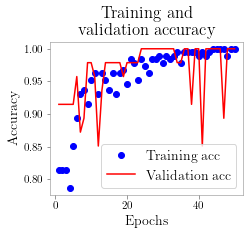

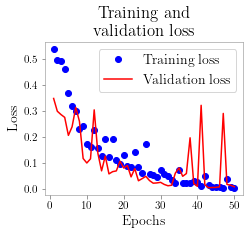

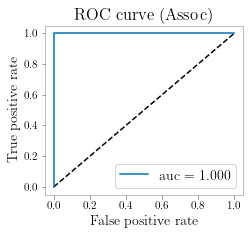

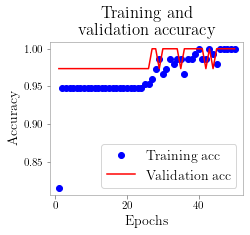

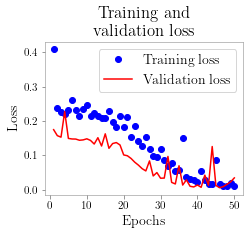

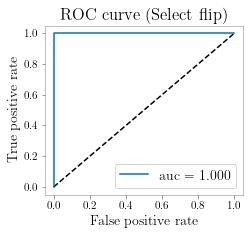

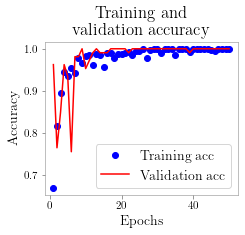

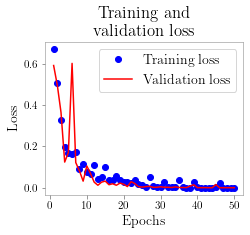

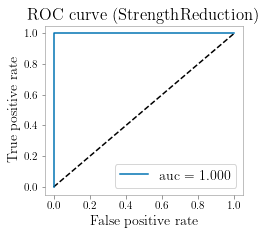

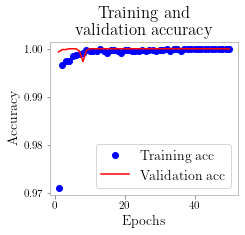

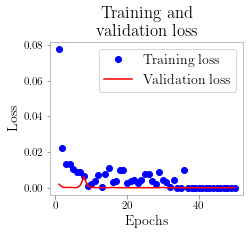

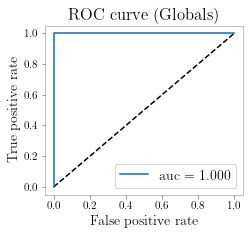

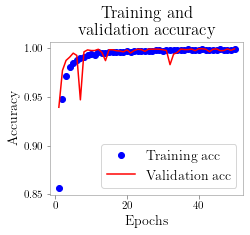

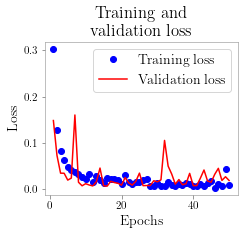

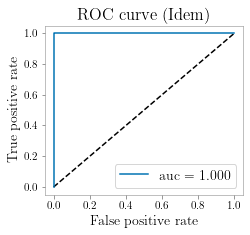

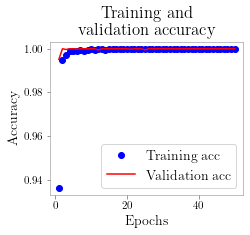

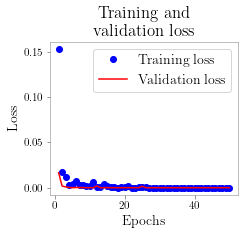

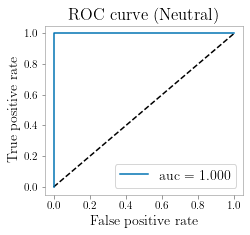

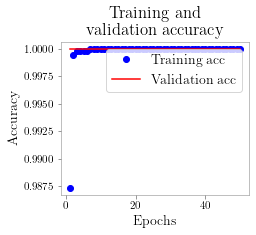

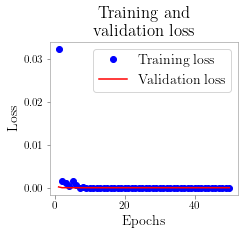

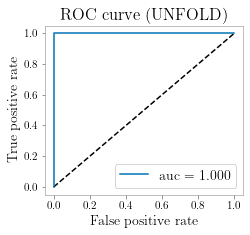

In [23]:
# Lets see if the classifier can learn specific mutators
for i, (benign, malign, name) in enumerate(datasets):
    print(name)

    augmented_benign = %time pdfast.read_csv(benign)
    augmented_malign = %time pdfast.read_csv(malign)


    augmented = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)
    train, test = split(augmented, 0.8)

    minost = MINOS()
    minost.fit(train, test, model_name=f"{name}.model.h5")

    print(f"Augmented dataset ({name})")
    meta = train.groupby(by='CLASS').apply(lambda x: len(x))
    display(meta)
    print("Test")
    meta = test.groupby(by='CLASS').apply(lambda x: len(x))
    display(meta)

    
    test_labels = test["CLASS"]
    predictions = minost.predict(test)
    print(f"Accuracy: {accuracy(predictions, test_labels)}")
    predictions = predictions.values
    
    test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
    auc_keras_val = auc_keras(fpr_keras, tpr_keras)


    # Potting roc 
    plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_TRAIN_{name}.pdf", title=f"ROC curve ({name})")
    print("======================================================\n\n")